# One-shot one-step LSTM Model on Cascadia
Author: Camilla Billari <br> 
Date: 27/01/24

Fitting a one-shot multi-step LSTM to the Cascadia dataset.

In [1]:
# Import relevant libraries
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm
import local_paths

# Change local path
sys.path.append(local_paths.MAIN_DIRECTORY)

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset

In [3]:
# Check if CUDA (NVIDIA GPU acceleration) is available
if torch.cuda.is_available():
    dev, map_location = "cuda", None  # Use GPU
    print(
        f"Total GPUs available: {torch.cuda.device_count()}"
    )  # Display GPU count
    !nvidia-smi  # Display GPU details using nvidia-smi
else:
    dev, map_location = "cpu", "cpu"  # Use CPU
    print("No GPU available.")

# Set PyTorch device based on the chosen device (cuda or cpu)
device = torch.device(dev)

No GPU available.


## Load Data

In [4]:
# Access Cascadia and output dataframe head - need to ask Pritt about his loader
EXP = "cascadia"
dataset = SlowEarthquakeDataset([EXP])

ds_exp = dataset[EXP]
X, Y, t = ds_exp["X"], ds_exp["Y"], ds_exp["t"]

df = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[ds_exp["hdrs"]["X"], *ds_exp["hdrs"]["Y"], ds_exp["hdrs"]["t"]],
)

df.head()

,seg_avg,seg_0,seg_1,seg_2,seg_3,seg_4,seg_5,seg_6,seg_7,seg_8,...,seg_187,seg_188,seg_189,seg_190,seg_191,seg_192,seg_193,seg_194,seg_195,time
0,1.510314e+08,87022.678176,-51216.196044,-195371.505863,-252388.298108,372090.056832,290238.755195,271991.646241,218795.685053,87096.609524,...,-714770.112748,-631423.743396,-693599.810348,-7.208255e+05,-739527.228854,-471014.225482,-6.757540e+05,-350155.612260,-517024.526987,2007.000700
1,1.256806e+08,118857.552212,64765.192887,-66943.170211,-125253.475061,510980.726973,375269.217942,323695.517273,312924.577753,-6911.497818,...,-506075.873333,-448764.275644,-391456.474306,-9.886575e+05,-958004.348328,-740390.446945,-8.927657e+05,-466337.939160,-928475.702850,2007.003438
2,1.074901e+08,-113120.619296,-100329.909243,-117236.092138,-63257.566664,87699.655400,15131.208777,-22576.356489,-13975.055467,-177396.925200,...,-421853.932989,-333693.022748,-204519.903296,-7.137062e+05,-715494.785171,-542145.799983,-6.803446e+05,-366915.287037,-572674.592498,2007.006176
3,1.447256e+08,-51897.143096,-61146.543996,-108560.424295,-80686.019435,178525.612880,98101.791008,48849.079713,53199.150697,-139909.026614,...,-655215.504038,-473799.573780,-345621.989210,-9.187762e+05,-927868.499626,-679886.516377,-8.823582e+05,-474262.121982,-695698.483285,2007.008914
4,1.787377e+08,-60139.943735,-118351.239477,-228181.280629,-226276.200039,270908.204014,154758.192851,92016.023222,86065.362414,-174784.005040,...,-916992.338832,-753637.001609,-546489.401328,-1.036981e+06,-934869.092836,-938970.117667,-1.106399e+06,-800182.900760,-897332.083419,2007.011651


In [5]:
df = df.dropna(axis=1)

# 3883 samples, so no need for downsampling
print("N samples: {}".format(len(df)))

N samples: 3883


## Data Pre-processing

### Denoising

In [6]:
# # First obtain a Fourier Transform of the signal to decide on cut-off frequency of the low pass filter
# time = range(len(segment_avg))

# # Perform FFT
# fft_result = np.fft.fft(segment_avg)
# frequencies = np.fft.fftfreq(len(time), time[1] - time[0])

# # Plot the original signal and its frequency domain representation
# plt.plot(frequencies, np.abs(fft_result), label="FFT Result")
# plt.title("Frequency Domain Representation")
# plt.xlabel("Frequency")
# plt.ylabel("Amplitude")
# plt.legend()
# plt.show()

In [7]:
# from scipy.signal import butter, filtfilt

# # Filter requirements.
# T = 3883  # Sample Period
# fs = 1  # sample rate, Hz
# cutoff = (
#     0.1  # desired cutoff frequency of the filter, Hz, based on the FFT above
# )
# nyq = 0.5 * fs  # Nyquist Frequency
# order = 2  # sin wave can be approx represented as quadratic
# n = int(T * fs)  # total number of samples

### Downsampling

In [8]:
SMOOTHING_WINDOW = 5
DOWNSAMPLING_FACTOR = 1

# Moving average smoothing - causal filter (centee=False)
downsampled_df = (
    df.rolling(window=int(SMOOTHING_WINDOW*5), step=int(DOWNSAMPLING_FACTOR), center=False).mean().dropna()
)
downsampled_df = downsampled_df.reset_index(drop=True)
downsampled_df = downsampled_df.dropna()
print("N downsampled samples: {}".format(len(downsampled_df)))
downsampled_df.head()

N downsampled samples: 3859


,seg_avg,seg_0,seg_1,seg_2,seg_3,seg_4,seg_5,seg_6,seg_7,seg_8,...,seg_187,seg_188,seg_189,seg_190,seg_191,seg_192,seg_193,seg_194,seg_195,time
0,1.363116e+08,27787.531296,-820.874068,-66293.696243,-54302.297239,258428.336524,178332.019357,109699.298948,122292.017615,-108897.055124,...,-601872.183709,-501342.569580,-406924.057402,-794822.626195,-772200.648652,-600879.480613,-756889.874904,-439476.088326,-666169.484322,2007.033554
1,1.340034e+08,18272.571216,-4373.636224,-65646.060075,-50465.416374,245986.264182,165833.363508,95096.593682,110677.039932,-124052.688803,...,-581521.287456,-485060.708945,-384217.781020,-775755.571926,-750432.008531,-589475.932933,-739393.009470,-431645.139918,-654572.883194,2007.036292
2,1.318409e+08,5806.065538,-13373.005598,-70257.078510,-51526.130989,225875.714436,147607.081187,76649.317269,93518.723516,-136856.144823,...,-563981.858013,-471468.594952,-368560.038421,-737659.749292,-711451.853821,-561347.037084,-705829.072650,-415458.760908,-619208.220290,2007.039030
3,1.295934e+08,916.428299,-17692.586610,-74906.004245,-57308.886741,222867.678140,142984.027001,73090.960920,89246.348472,-141190.668027,...,-545480.025985,-461249.467582,-360007.467113,-707204.212974,-678768.020719,-537447.358488,-676636.136198,-400576.900674,-594026.374308,2007.041768
4,1.246631e+08,-4502.146049,-22266.556302,-79361.112704,-62982.667657,220086.002566,138375.442356,70863.007889,85648.836988,-142464.049615,...,-510563.890233,-441222.986433,-343092.780145,-667194.847839,-637411.322454,-505307.605508,-636011.777432,-377095.650073,-563581.580354,2007.044506


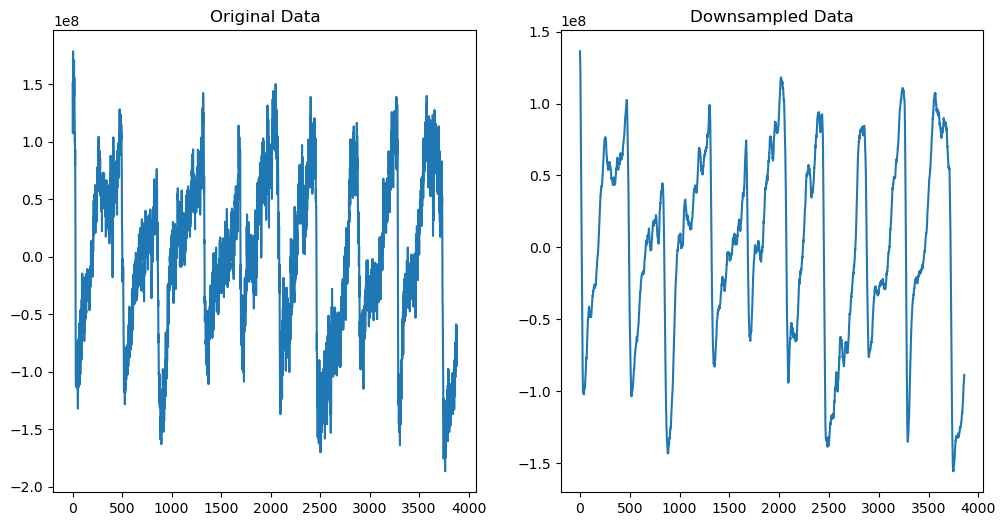

In [9]:
# Plot relevant features in the original and downsampled datasets
plt.figure(figsize=(12, 6))

# Example: Plotting the first feature in the dataset
plt.subplot(1, 2, 1)
plt.plot(
    range(len(df)), df["seg_avg"], label="Original Data"
)
# plt.plot(df["obs_shear_stress"])
plt.title("Original Data")

plt.subplot(1, 2, 2)
plt.plot(
    range(len(downsampled_df)),
    downsampled_df["seg_avg"],
    label="Downsampled Data"
)
# plt.plot(downsampled_df["obs_shear_stress"])
plt.title("Downsampled Data")

plt.show()

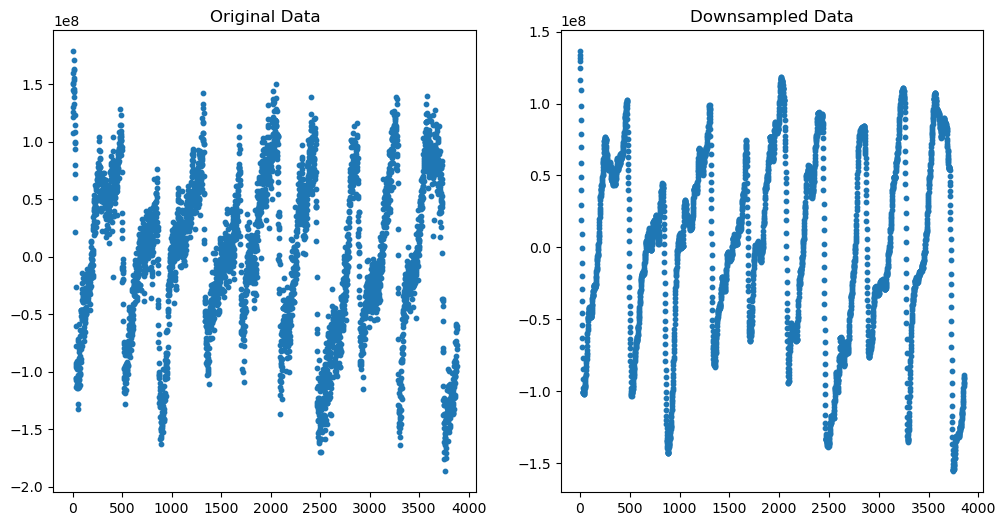

In [10]:
# Plot relevant features in the original and downsampled datasets
plt.figure(figsize=(12, 6))

# Example: Plotting the first feature in the dataset
plt.subplot(1, 2, 1)
plt.scatter(
    range(len(df)), df["seg_avg"], label="Original Data", s=10
)
# plt.plot(df["obs_shear_stress"])
plt.title("Original Data")

plt.subplot(1, 2, 2)
plt.scatter(
    range(len(downsampled_df)),
    downsampled_df["seg_avg"],
    label="Downsampled Data",
    s=10,
)
# plt.plot(downsampled_df["obs_shear_stress"])
plt.title("Downsampled Data")

plt.show()

## Creating the datastet

In [11]:
def create_dataset(dataset, lookback, forecast):
    """Transform a time series into a prediction dataset

    Args:
        dataset: Numpy array of time series (first dimension is the time steps).
        lookback: Size of the window for prediction.
        forecast: Number of time steps to predict into the future.
    Return:
        X_tensor: Pytorch tensor of the X windowed features
        y_tensor: Pytorch tensor of the y windowed targets
    """
    X, y = [], []

    # Create input features (X) and corresponding targets (y) for prediction
    for i in range(len(dataset) - lookback - forecast + 1):
        feature = dataset[i : i + lookback]
        target = dataset[i + lookback : i + lookback + forecast]
        X.append(feature)
        y.append(target)

    # Convert the lists to PyTorch tensors - note list->arrays->tensors is faster than list->tensors
    return torch.from_numpy(np.array(X, dtype=np.float32)), torch.from_numpy(
        np.array(y, dtype=np.float32)
    )

In [12]:
# Create a seed for the dataset and model
SEED = 17

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [13]:
# Extract time series data
# timeseries = df["seg_avg"]
timeseries = downsampled_df["seg_avg"]
# timeseries = denoised_df

# Define lookback and forecast values
LOOKBACK, FORECAST = 80, 30

# Create X & Y dataset
X, y = create_dataset(timeseries, LOOKBACK, FORECAST)

In [14]:
N_FORECAST_WINDOWS = 30
test_size = N_FORECAST_WINDOWS * FORECAST
excess = X[:-test_size].shape[0] - FORECAST * (
    X[:-test_size].shape[0] // FORECAST
)

X_test, y_test = X[-test_size:], y[-test_size:]
X_train, y_train = X[excess:-test_size], y[excess:-test_size]


# Display shapes of the created datasets
print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")

Training data shapes: torch.Size([2850, 80]), torch.Size([2850, 30])
Testing data shapes: torch.Size([900, 80]), torch.Size([900, 30])


### Normalising with scaler based on the training set

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Note - we should only fit the scaler to the training set, not the test set!! Super important
# We only transform the test set, and we will then do an inverse transform later when evaluating.
X_train_sc, X_test_sc = scaler_X.fit_transform(X_train), scaler_X.transform(
    X_test
)
y_train_sc, y_test_sc = scaler_y.fit_transform(y_train), scaler_y.transform(
    y_test
)

# Turn all scaled arrays into float tensors
X_train_sc, X_test_sc = (
    torch.from_numpy(X_train_sc).float(),
    torch.from_numpy(X_test_sc).float(),
)
y_train_sc, y_test_sc = (
    torch.from_numpy(y_train_sc).float(),
    torch.from_numpy(y_test_sc).float(),
)

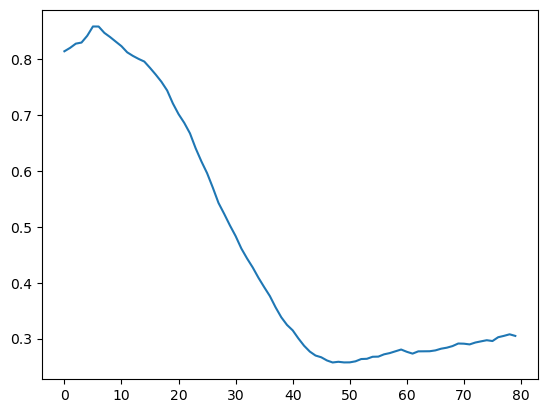

In [16]:
# Plot 3rd X_test window
plt.plot(X_test_sc[2, :])

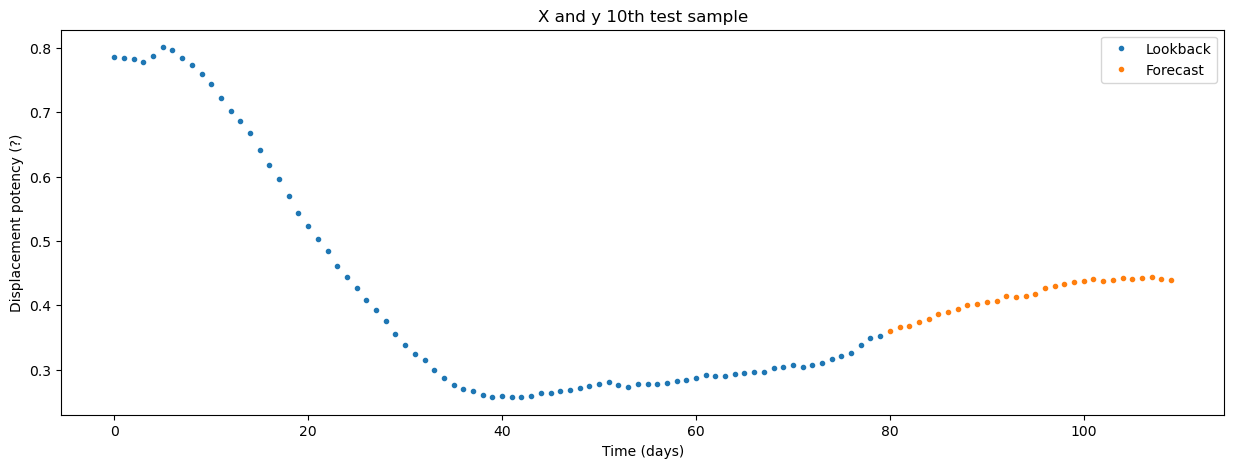

In [17]:
# Plot an example X and y sample
plt.figure(figsize=(15, 5))
plt.plot(X_test_sc[10], ".", label="Lookback")
# Plot the y sample shifted by the length of the lookback
plt.plot(np.arange(LOOKBACK, LOOKBACK + FORECAST), y_test_sc[10], ".", label="Forecast")
plt.title("X and y 10th test sample")
plt.xlabel("Time (days)")
plt.ylabel("Displacement potency (?)")
plt.legend()
plt.show()

## Modelling

In [18]:
import torch.nn as nn


class MultiStepLSTM(nn.Module):
    """Subclass of nn.Module"""

    def __init__(
        self, n_variates=1, hidden_size=50, n_layers=1, output_size=FORECAST
    ):
        super().__init__()
        self.n_variates = n_variates
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.output_size = output_size

        # LSTM layer with specified input size, hidden size, and batch_first
        self.lstm = nn.LSTM(
            input_size=self.n_variates,
            hidden_size=self.hidden_size,
            num_layers=self.n_layers,
            batch_first=True,
        )

        # Linear layer mapping the LSTM output to the forecasted values
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        """Forward pass through the LSTM layer."""
        # Initialise hidden state and cell state
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)

        # LSTM layer
        lstm_out, _ = self.lstm(x, (h0, c0))

        # Extract the last time step output from the LSTM output
        lstm_out = lstm_out[:, -1, :]

        # Linear layer for the final output (forecasted values)
        output = self.linear(lstm_out)

        return output

### Training

In [19]:
# Move training and testing data to the specified device (cuda or cpu)
X_train_sc = X_train_sc.to(device)
y_train_sc = y_train_sc.to(device)
X_test_sc = X_test_sc.to(device)
y_test_sc = y_test_sc.to(device)

In [20]:
import torch.optim as optim
import torch.utils.data as data
from sklearn.metrics import r2_score

# Define the number of input variates and hidden size
N_VARIATES = 1
HIDDEN_SIZE = 50
N_LAYERS = 1
OUTPUT_SIZE = FORECAST

# Instantiate the AirModel and move it to the specified device
model = MultiStepLSTM(N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE).to(
    device
)

# Define Adam optimizer and Mean Squared Error (MSE) loss function
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

# Create a DataLoader for training batches
loader = data.DataLoader(
    data.TensorDataset(X_train_sc, y_train_sc), shuffle=True, batch_size=32
)

# Set the number of training epochs
n_epochs = 75
pbar = tqdm.tqdm(range(n_epochs))

# Lists to store RMSE values for plotting
train_rmse_list = []
test_rmse_list = []

# Training loop
for epoch in pbar:
    model.train()

    # Iterate through batches in the DataLoader
    for X_batch, y_batch in loader:
        # Reshape input for univariate (add a dimension) and model
        y_pred = model(X_batch.unsqueeze(-1))
        loss = loss_fn(y_pred, y_batch)

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()

    with torch.no_grad():  # do not consider gradient in evaluating - no backprop
        # Evaluate model on training data
        y_train_pred = model(X_train_sc.unsqueeze(-1))
        y_train_pred = torch.Tensor(
            scaler_y.inverse_transform(y_train_pred.cpu())
        )
        train_rmse = np.sqrt(loss_fn(y_train_pred, y_train))
        train_rmse_list.append(train_rmse.item())
        train_r2 = r2_score(y_train, y_train_pred)

        # Evaluate model on testing data
        y_test_pred = model(X_test_sc.unsqueeze(-1))
        y_test_pred = torch.Tensor(
            scaler_y.inverse_transform(y_test_pred.cpu())
        )
        test_rmse = np.sqrt(loss_fn(y_test_pred, y_test))
        test_rmse_list.append(test_rmse.item())
        test_r2 = r2_score(y_test, y_test_pred)

    # Update progress bar with training and testing RMSE
    pbar.set_description(
        f"Epoch [{epoch+1}/{n_epochs}], Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}, Last Batch Loss: {loss.item():.4f}"
    )

Epoch [75/75], Train RMSE: 17592996.0000, Test RMSE: 25842248.0000, Train R2: 0.9171, Test R2: 0.8836, Last Batch Loss: 0.0016: 100%|██████████| 75/75 [04:14<00:00,  3.40s/it]


## Results

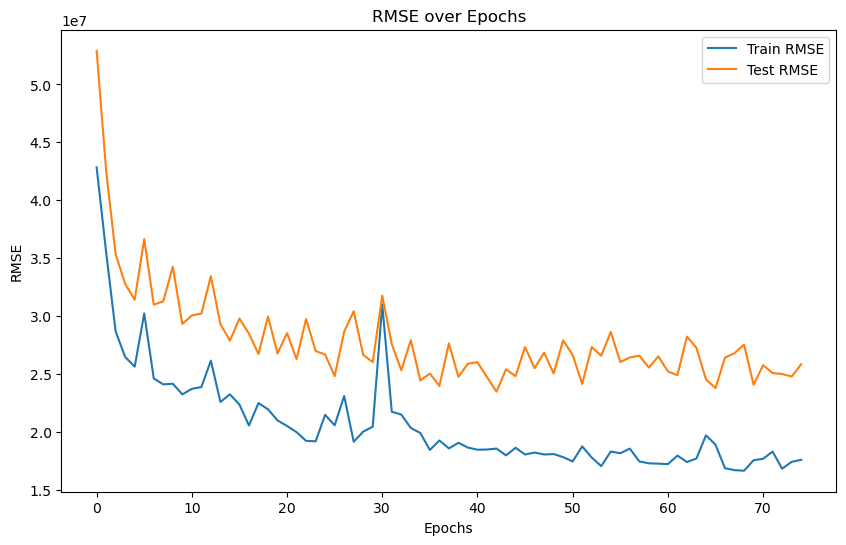

In [21]:
# Plot RMSE over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(0, n_epochs), train_rmse_list, label="Train RMSE")#, marker=".")
plt.plot(range(0, n_epochs), test_rmse_list, label="Test RMSE")#, marker=".")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("RMSE over Epochs")
plt.legend()
plt.show()

In [22]:
train_outputs = y_train_pred
test_outputs = y_test_pred

train_plot = np.array(
    [train_outputs[idx] for idx in range(0, len(train_outputs), FORECAST)]
).reshape(-1, 1)

test_plot = np.array(
    [test_outputs[idx] for idx in range(0, len(test_outputs), FORECAST)]
).reshape(-1, 1)

combined_plot = np.concatenate((train_plot, test_plot))

test_start_index = len(timeseries) - len(y_test) - LOOKBACK

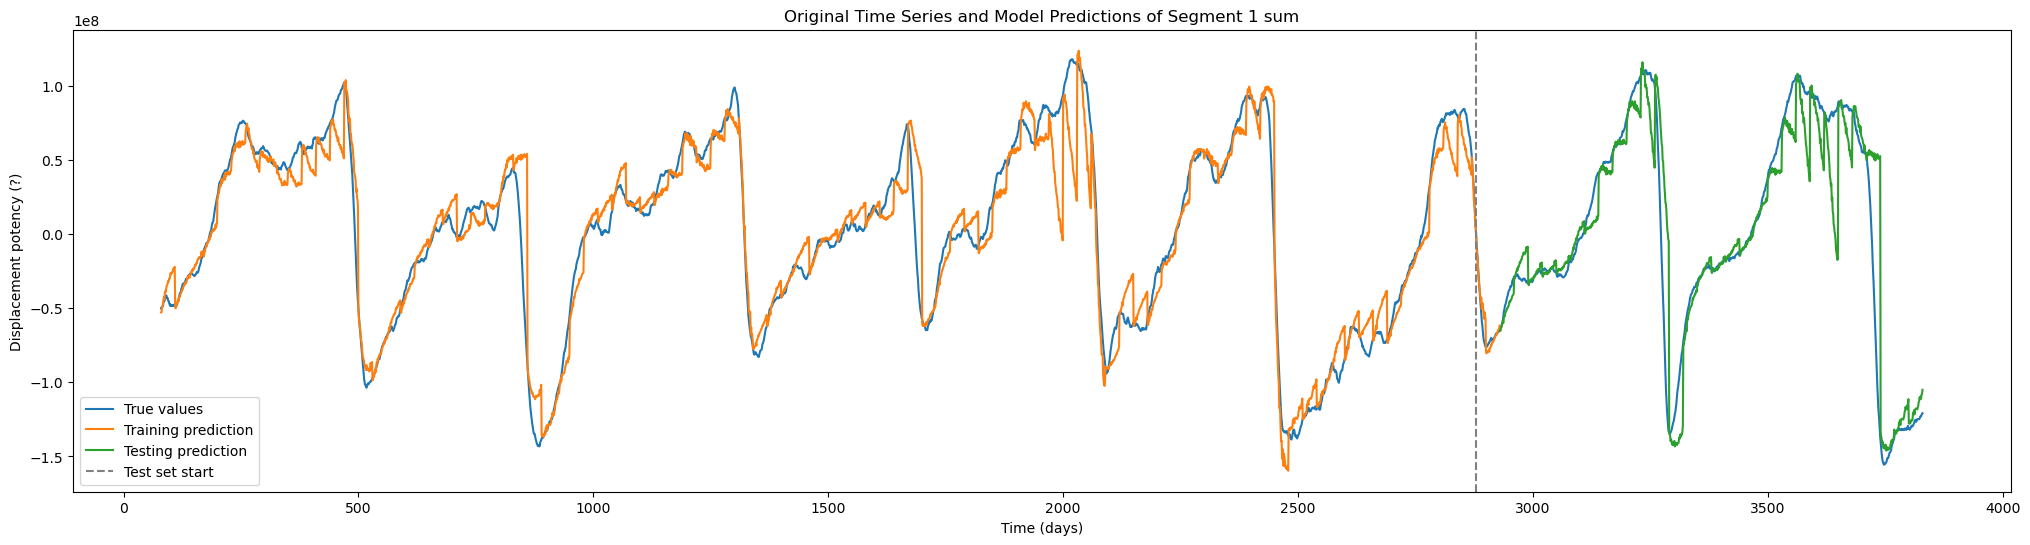

In [23]:
plt.figure(figsize=(25, 6))
plt.plot(
    range(LOOKBACK, LOOKBACK + len(combined_plot)),
    np.concatenate((y_train[:, 0], y_test[:, 0])),
    label="True values",
)

plt.plot(
    range(LOOKBACK, LOOKBACK + len(train_plot)),
    train_plot,
    label="Training prediction",
)
plt.plot(
    range(LOOKBACK + len(train_plot), LOOKBACK + len(combined_plot)),
    test_plot,
    label="Testing prediction",
)

plt.axvline(
    x=test_start_index, color="gray", linestyle="--", label="Test set start"
)
plt.title("Original Time Series and Model Predictions of Segment 1 sum")
plt.xlabel("Time (days)")
plt.ylabel("Displacement potency (?)")
plt.legend()
plt.show()

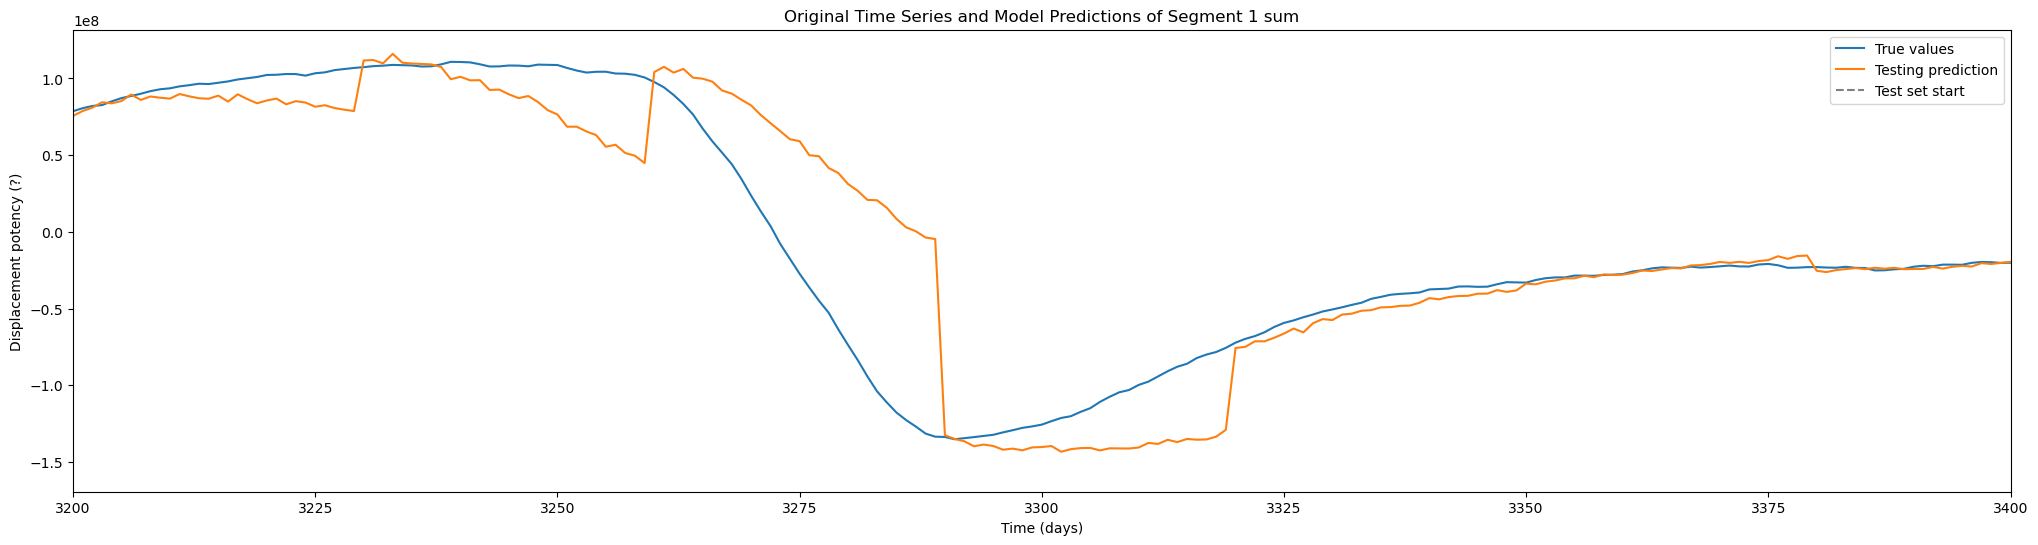

In [24]:
plt.figure(figsize=(25, 6))
plt.plot(
    range(LOOKBACK, LOOKBACK + len(combined_plot)),
    np.concatenate((y_train[:, 0], y_test[:, 0])),
    label="True values",
)
plt.plot(
    range(LOOKBACK + len(train_plot), LOOKBACK + len(combined_plot)),
    test_plot,
    label="Testing prediction",
)

plt.axvline(
    x=test_start_index, color="gray", linestyle="--", label="Test set start"
)

# Set x-axis limits to focus on the time range 3400-3500
plt.xlim(3200, 3400)
plt.title("Original Time Series and Model Predictions of Segment 1 sum")
plt.xlabel("Time (days)")
plt.ylabel("Displacement potency (?)")
plt.legend()
plt.show()